# MNIST data set loader

In [1]:
import gzip
import numpy as np
import os

def load_mnist(base='./'):

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

# Neural network class

In [108]:
import random
from tqdm import tqdm

def sigmoid(z):
    """The sigmoid function."""
    return 1.0 / (1.0 + np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z) * (1 - sigmoid(z))

class Network(object):

    def __init__(self, sizes):

        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [ np.random.randn(y, 1) for y in sizes[1:] ]
        self.weights = [ np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:]) ]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
            
        return a

    def SGD(self, training_data, epochs, mini_batch_size, learning_rate):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs."""
        n = len(training_data)
        
        for j in xrange(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in xrange(0, n, mini_batch_size) ]
            
            for mini_batch in tqdm(mini_batches):
                self.update_mini_batch(mini_batch, learning_rate)
                
            print "Epoch {0} complete".format(j)

    def update_mini_batch(self, mini_batch, learning_rate):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``"""
        nabla_b = [ np.zeros(b.shape) for b in self.biases ]
        nabla_w = [ np.zeros(w.shape) for w in self.weights ]
        
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [ nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b) ]
            nabla_w = [ nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w) ]
        
        self.weights = [ w - (learning_rate / len(mini_batch)) * nw
                        for w, nw in zip(self.weights, nabla_w) ]
        
        self.biases = [ b - (learning_rate / len(mini_batch)) * nb
                       for b, nb in zip(self.biases, nabla_b) ]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function. ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        
        nabla_b = [ np.zeros(b.shape) for b in self.biases ]
        nabla_w = [ np.zeros(w.shape) for w in self.weights ]
        
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            #print  np.dot(w, activation).shape, w.shape, b.shape, z.shape
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
            
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
            
        nabla_b[-1] = delta
        #print delta.shape, activations[-2].shape
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())

        for l in xrange(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l + 1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
            
        return (nabla_b, nabla_w)

    #def calculate_loss(self, output_activations, y):
    #    return np.sum((output_activations - y) ** 2)/y.size
    
    def cost_derivative(self, output_activations, y):
        """Vector of partial derivatives for the cost function"""
        return (output_activations - y)

# Example

(784, 1) (50000, 10, 1)


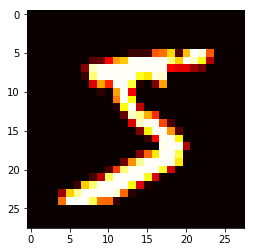

In [109]:
from matplotlib import pylab

X_train, y_train, X_val, y_val, X_test, y_test = load_mnist()
X_train = X_train.reshape(-1, 28 * 28, 1) 
X_test = X_test.reshape(-1, 28 * 28, 1)
Y_train = np.zeros((len(y_train), 10, 1))
Y_test = np.zeros((len(y_test), 10, 1))

for i in xrange(len(y_train)):
    Y_train[i][y_train[i]] = 1.0

for i in xrange(len(y_test)):
    Y_test[i][y_test[i]] = 1.0

print X_train[0].shape, Y_train.shape
pylab.imshow(X_train[0].reshape(28, 28), cmap=pylab.cm.hot)
pylab.show()

In [110]:
training_set = [ (X_train[i,], X_train[i]) for i in xrange(len(X_train)) ]
test_set = [ (X_test[i], X_test[i]) for i in xrange(len(X_test)) ]

In [111]:
Net = Network([28 * 28, 30, 28 * 28])

In [112]:
Net.SGD(training_set, 50, 50, 1.0)




  0%|          | 0/1000 [00:00<?, ?it/s]


  0%|          | 2/1000 [00:00<00:57, 17.41it/s]


  0%|          | 5/1000 [00:00<00:51, 19.37it/s]


  1%|          | 8/1000 [00:00<00:45, 21.63it/s]




  1%|          | 12/1000 [00:00<00:42, 23.31it/s]


  2%|▏         | 15/1000 [00:00<00:41, 23.59it/s]


  2%|▏         | 18/1000 [00:00<00:39, 24.89it/s]


  2%|▏         | 22/1000 [00:00<00:37, 26.43it/s]


  3%|▎         | 26/1000 [00:00<00:34, 27.88it/s]


  3%|▎         | 29/1000 [00:01<00:35, 27.52it/s]


  3%|▎         | 32/1000 [00:01<00:36, 26.87it/s]


  4%|▎         | 36/1000 [00:01<00:34, 27.99it/s]


  4%|▍         | 39/1000 [00:01<00:34, 28.14it/s]


  4%|▍         | 43/1000 [00:01<00:33, 28.69it/s]


  5%|▍         | 46/1000 [00:01<00:35, 27.06it/s]


  5%|▍         | 49/1000 [00:02<00:55, 17.03it/s]


  5%|▌         | 53/1000 [00:02<00:47, 20.06it/s]


  6%|▌         | 56/1000 [00:02<00:44, 21.08it/s]


  6%|▌         | 59/1000 [00:02<00:58, 16.05it/s]


  6%|▌         | 62

KeyboardInterrupt: 

In [76]:
num_of_example = 777
pylab.subplot(121)
pylab.imshow(X_test[num_of_example].reshape(28, 28), cmap=pylab.cm.hot)
pylab.subplot(122)
pylab.imshow(Net.feedforward(X_test[num_of_example]).reshape(28, 28), cmap=pylab.cm.hot)
pylab.show()

ValueError: shapes (30,784) and (1,28,28) not aligned: 784 (dim 1) != 28 (dim 1)

In [63]:
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist()
print X_train.shape, y_train.shape

(50000, 1, 28, 28) (50000,)


In [64]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *

input_X = T.tensor4("X")
target_Y = T.tensor4("Y")

In [65]:
net = lasagne.layers.InputLayer((None, 1, 28, 28), input_X, "input")
net = lasagne.layers.DenseLayer(net, 16)
net = lasagne.layers.DenseLayer(net, 28 * 28)
net = lasagne.layers.ReshapeLayer(net, (-1, 1, 28, 28))

In [66]:
predicted_Y = lasagne.layers.get_output(net)

In [67]:
weights = lasagne.layers.get_all_params(net)

In [68]:
loss = lasagne.objectives.squared_error(predicted_Y, target_Y).mean()
updates_sgd = lasagne.updates.sgd(loss, weights,learning_rate=1.0)

In [69]:
#функция, которая обучает сеть на 1 шаг и возвращащет значение функции потерь
train_fun = theano.function([input_X, target_Y], [loss], updates=updates_sgd)

In [70]:
predictor = theano.function([input_X], [predicted_Y])

In [71]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [72]:
import time

num_epochs = 25
batch_size = 50

for epoch in xrange(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, X_train, batch_size):
        inputs, targets = batch
        train_err_batch = train_fun(inputs, targets)
        train_err += sum(train_err_batch)
        train_batches += 1
    # print the results for epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    #print("  validation accuracy:\t\t{:.2f} %".format(
    #    val_acc / val_batches * 100))

1000it [00:05, 180.22it/s]
8it [00:00, 75.82it/s]

Epoch 1 of 25 took 5.317s
  training loss (in-iteration):		0.067247


1000it [00:05, 250.98it/s]
19it [00:00, 184.08it/s]

Epoch 2 of 25 took 5.510s
  training loss (in-iteration):		0.047354


1000it [00:05, 176.63it/s]
26it [00:00, 251.47it/s]

Epoch 3 of 25 took 5.665s
  training loss (in-iteration):		0.040923


1000it [00:06, 151.65it/s]
18it [00:00, 168.65it/s]

Epoch 4 of 25 took 6.599s
  training loss (in-iteration):		0.036961


1000it [00:05, 188.73it/s]
12it [00:00, 118.35it/s]

Epoch 5 of 25 took 5.311s
  training loss (in-iteration):		0.035701


1000it [00:05, 182.34it/s]
14it [00:00, 139.43it/s]

Epoch 6 of 25 took 5.495s
  training loss (in-iteration):		0.035158


1000it [00:06, 160.40it/s]
10it [00:00, 99.55it/s]

Epoch 7 of 25 took 6.247s
  training loss (in-iteration):		0.034860


1000it [00:04, 208.56it/s]
12it [00:00, 119.80it/s]

Epoch 8 of 25 took 4.804s
  training loss (in-iteration):		0.034486


1000it [00:05, 185.83it/s]
13it [00:00, 124.06it/s]

Epoch 9 of 25 took 5.396s
  training loss (in-iteration):		0.033461


1000it [00:05, 186.72it/s]
10it [00:00, 99.52it/s]

Epoch 10 of 25 took 5.363s
  training loss (in-iteration):		0.032566


1000it [00:05, 191.85it/s]
13it [00:00, 118.56it/s]

Epoch 11 of 25 took 5.228s
  training loss (in-iteration):		0.031911


1000it [00:06, 153.73it/s]
17it [00:00, 165.80it/s]

Epoch 12 of 25 took 6.521s
  training loss (in-iteration):		0.031451


1000it [00:05, 171.12it/s]
6it [00:00, 46.69it/s]

Epoch 13 of 25 took 5.857s
  training loss (in-iteration):		0.031189


1000it [00:06, 163.00it/s]
20it [00:00, 196.79it/s]

Epoch 14 of 25 took 6.151s
  training loss (in-iteration):		0.031006


1000it [00:05, 174.39it/s]
20it [00:00, 193.77it/s]

Epoch 15 of 25 took 5.748s
  training loss (in-iteration):		0.030855


1000it [00:05, 186.40it/s]
20it [00:00, 194.73it/s]

Epoch 16 of 25 took 5.399s
  training loss (in-iteration):		0.030686


1000it [00:05, 191.24it/s]
24it [00:00, 234.08it/s]

Epoch 17 of 25 took 5.252s
  training loss (in-iteration):		0.030326


1000it [00:04, 242.88it/s]
24it [00:00, 236.54it/s]

Epoch 18 of 25 took 4.133s
  training loss (in-iteration):		0.029957


1000it [00:04, 211.63it/s]
18it [00:00, 177.32it/s]

Epoch 19 of 25 took 4.740s
  training loss (in-iteration):		0.029755


1000it [00:06, 165.51it/s]
15it [00:00, 146.62it/s]

Epoch 20 of 25 took 6.061s
  training loss (in-iteration):		0.029634


1000it [00:05, 187.91it/s]
18it [00:00, 179.25it/s]

Epoch 21 of 25 took 5.328s
  training loss (in-iteration):		0.029491


1000it [00:05, 184.09it/s]
18it [00:00, 176.23it/s]

Epoch 22 of 25 took 5.441s
  training loss (in-iteration):		0.029358


1000it [00:04, 223.23it/s]
12it [00:00, 117.49it/s]

Epoch 23 of 25 took 4.489s
  training loss (in-iteration):		0.029319


1000it [00:05, 193.27it/s]
21it [00:00, 183.16it/s]

Epoch 24 of 25 took 5.184s
  training loss (in-iteration):		0.029291


1000it [00:05, 183.63it/s]

Epoch 25 of 25 took 5.459s
  training loss (in-iteration):		0.029268


In [73]:
X_predicted = predictor(X_test)[0]

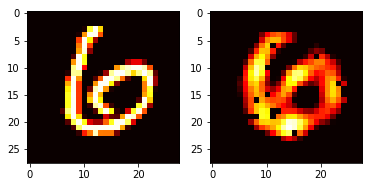

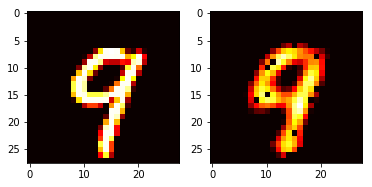

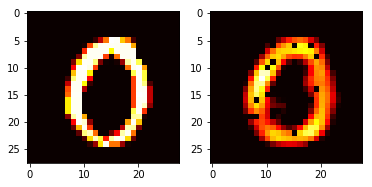

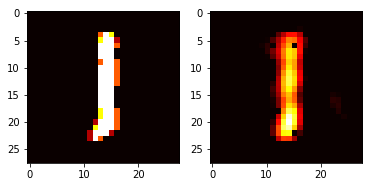

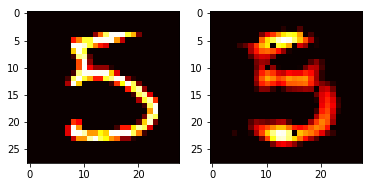

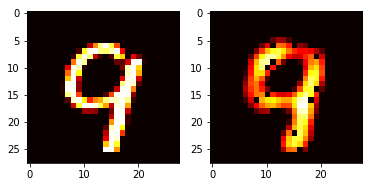

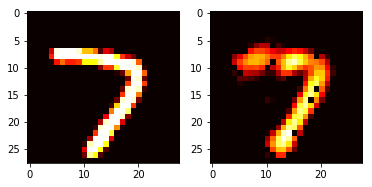

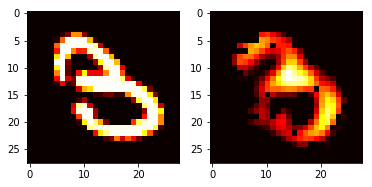

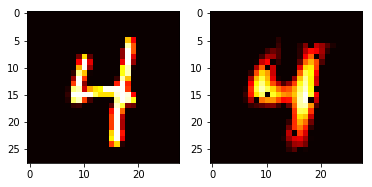

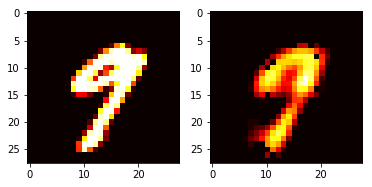

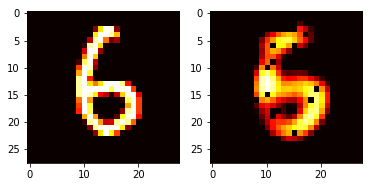

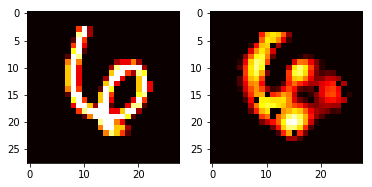

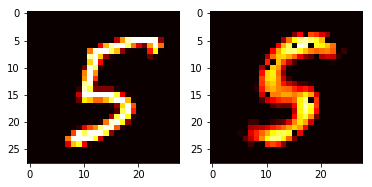

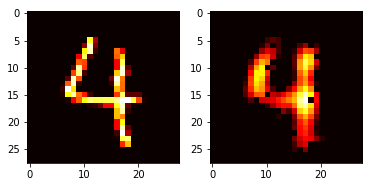

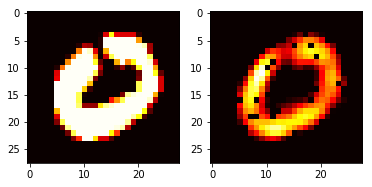

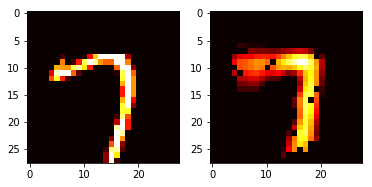

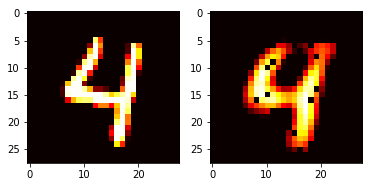

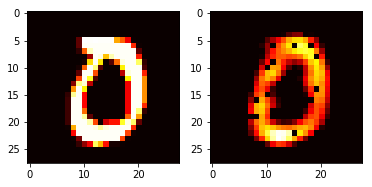

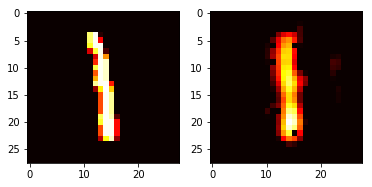

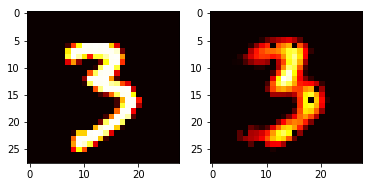

In [104]:
start = 11
num_of_examples = 20

for i in xrange(start, start + num_of_examples):
    pylab.figure()
    pylab.subplot(1, 2, 1)
    pylab.imshow(X_test[i].reshape(28, 28), cmap=pylab.cm.hot)
    pylab.subplot(1, 2, 2)
    pylab.imshow(X_predicted[i].reshape(28, 28), cmap=pylab.cm.hot)
    
pylab.show()